In [ ]:
%pip install -q pandas matplotlib seaborn scipy scikit-learn
from collections import Counter, defaultdict
import pickle
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


'''
This script analyzes all the extracted entities in terms of tdf-idf from time-series files based on legislation period and year.
"TPT/Entities" structures are created with the script find_time_series_entities.py
'''



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


'\nThis script analyzes all the extracted entities in terms of tdf-idf from time-series files based on legislation period and year.\n"TPT/Entities" structures are created with the script find_time_series_entities.py\n'

In [9]:
ENTITY_ROOT = "TPT/Entities"

# Step 1: Traverse all entity subfolders
grouped_entities = defaultdict(list)

for root, dirs, files in os.walk(ENTITY_ROOT):
    for file in files:
        if file.endswith(".pkl"):
            file_path = os.path.join(root, file)
            period_year = os.path.basename(root).replace("_txts", "")  # e.g. d27-y3
            try:
                with open(file_path, "rb") as f:
                    entities = pickle.load(f)
                    grouped_entities[period_year].extend(entities)
            except Exception as e:
                print(f"❌ Failed to load {file_path}: {e}")

In [10]:
from collections import defaultdict

entity_counts = {}
total_entities = 0
for period, entities in grouped_entities.items():
    entity_counts[period] = len(entities)
    total_entities += len(entities)

print(f"Total entities: {total_entities}")

# Sort periods in chronological order
sorted_periods = sorted(entity_counts.keys())
counts = [entity_counts[period] for period in sorted_periods]

Total entities: 322478


In [11]:
# Helper to extract (dönem, yıl) as sortable integers
def parse_period_year(name):
    match = re.match(r'd(\d+)-y(\d+)', name)
    if match:
        return int(match.group(1)), int(match.group(2))
    return float("inf"), float("inf")  # push malformed folders to the end

In [12]:
# Helper to recombine subwords
def recombine_subwords(entities):
    merged = []
    current = None

    for ent in entities:
        word = ent["word"]

        if word.startswith("##") and current:
            current["word"] += word[2:]
            current["end"] = ent["end"]
        else:
            if current:
                merged.append(current)
            current = ent.copy()

    if current:
        merged.append(current)

    return merged

In [13]:
# Step 2: Sort keys chronologically (dönem then yıl)
sorted_keys = sorted(grouped_entities.keys(), key=parse_period_year)
recombined_entities = {}
for group in sorted_keys:
    raw_entities = grouped_entities[group]
    merged_entities = recombine_subwords(raw_entities)
    recombined_entities[group] = merged_entities


In [ ]:
from __future__ import annotations
import os, re, json, pickle, hashlib, unicodedata
from collections import Counter
from typing import Dict, List

import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from rapidfuzz import process, fuzz
from scipy import sparse
from sklearn.feature_extraction.text import TfidfTransformer
import matplotlib.pyplot as plt


# 1. Normalize entity keys
import string

def normalise_entity_key(ent) -> str | None:
    if isinstance(ent, dict):
        word = ent.get('word', '').strip()
        group = ent.get('entity_group', '').strip()
    elif isinstance(ent, (list, tuple)) and len(ent) == 2:
        word, group = ent[0].strip(), ''
    else:
        word, group = str(ent).strip(), ''

    # Remove all punctuation
    word = word.translate(str.maketrans('', '', string.punctuation))

    # Filter out empty or too-short strings
    if len(word) < 2:
        return None

    return f"{word}-{group}" if group else word


ORG_ALIASES = {
    "TBMM": "TBMM",
    "Türkiye Büyük Millet Meclisi": "TBMM",
    "TÜRKİYE BÜYÜK MİLLET MECLİSİ": "TBMM",
    "Büyük Millet Meclisi": "TBMM",
    "BMM": "TBMM",
    "T B M M": "TBMM",
    "T. B. M. M.": "TBMM",
    "T.B.M.M.": "TBMM",
    "T.B.M.M": "TBMM",
    "TÜRKİYE BÜYÜK MİLLET MECLİSİ’NDE": "TBMM",
    "TBMM’de": "TBMM",
    "TBMM'DE": "TBMM",
    "TBMM'de": "TBMM",
    "tbmm": "TBMM",
    "tbmm’de": "TBMM",
    "Türkiye Büyük Millet Meclisi’nde": "TBMM",
    "TÜRKİYE BÜYÜK MİLLET MECLİSİ'NDE": "TBMM",
    "Türkiye B. M. Meclisi": "TBMM", 
    "T.Büyük Millet Meclisi": "TBMM", 
    "Tiirkiye" : "Türkiye",
    "Tıirkiye": "Türkiye"

}
HAND_CANONICALS = set(ORG_ALIASES.values())

def _clean(s: str) -> str:
    return re.sub(r"\W+", "", unicodedata.normalize("NFKD", s).lower())

def choose_canonical(cluster: List[str], freq: Dict[str, int] | None = None) -> str:
    for v in cluster:                       # 1) handcrafted wins
        if v in HAND_CANONICALS:
            return v
    if freq:                                # 2) most frequent spelling
        best = max(cluster, key=lambda x: freq.get(x, 0))
        if freq.get(best, 0) > 1:
            return best
    return min(cluster, key=lambda x: (_clean(x), len(_clean(x))))  # 3) shortest


In [15]:
"""
TF‑IDF over time with fast RapidFuzz aliasing
--------------------------------------------
* parallel fuzzy clustering (RapidFuzz cdist + C++ threads)
* cache alias_map.pkl

needs 
grouped_entities   # dict[bucket, list[NER‑dict]]
sorted_keys        # same keys, sorted
recombine_subwords # fn(tokens) -> list[NER‑dict]

"""


from rapidfuzz import process, fuzz
import numpy as np

def build_alias_map_fast(
    names: list[str],
    *,
    threshold: int = 90,
    min_len: int = 3,
    freq: dict[str, int] | None = None,
    cache_path: str = "alias_map.pkl",
    workers: int = -1,
    desc: str = "Alias clustering"
) -> dict[str, str]:
    
    names = sorted(set(names))
    sig = hashlib.md5(json.dumps(names).encode()).hexdigest()

    if os.path.exists(cache_path):
        with open(cache_path, "rb") as f:
            cached_sig, alias_map = pickle.load(f)
        if cached_sig == sig:
            print("✔ alias_map loaded from cache.")
            return alias_map

    clusters: list[list[str]] = []
    canon_keys: list[str] = []          

    for name in tqdm(names, desc=desc, unit="name"):

        key = _clean(name) 

        if len(key) < min_len:
            clusters.append([name])
            continue

        if canon_keys:
            # 1×J matrix of similarity scores (float32)
            scores = process.cdist(
                [key], canon_keys,
                scorer=fuzz.token_set_ratio,
                workers=workers
            )
            best_idx = int(np.argmax(scores))
            best_score = float(scores[0, best_idx])
        else:
            best_score = -1  # forces new cluster

        if best_score < threshold:
            canon_keys.append(key)
            clusters.append([name])
        else:
            clusters[best_idx].append(name)


    alias_map: dict[str, str] = {}
    for cl in clusters:
        canon = ORG_ALIASES.get(cl[0], choose_canonical(cl, freq))
        for v in cl:
            alias_map[v] = canon

    with open(cache_path, "wb") as f:
        pickle.dump((sig, alias_map), f)

    return alias_map


Alias clustering:   0%|          | 0/36674 [00:00<?, ?name/s]

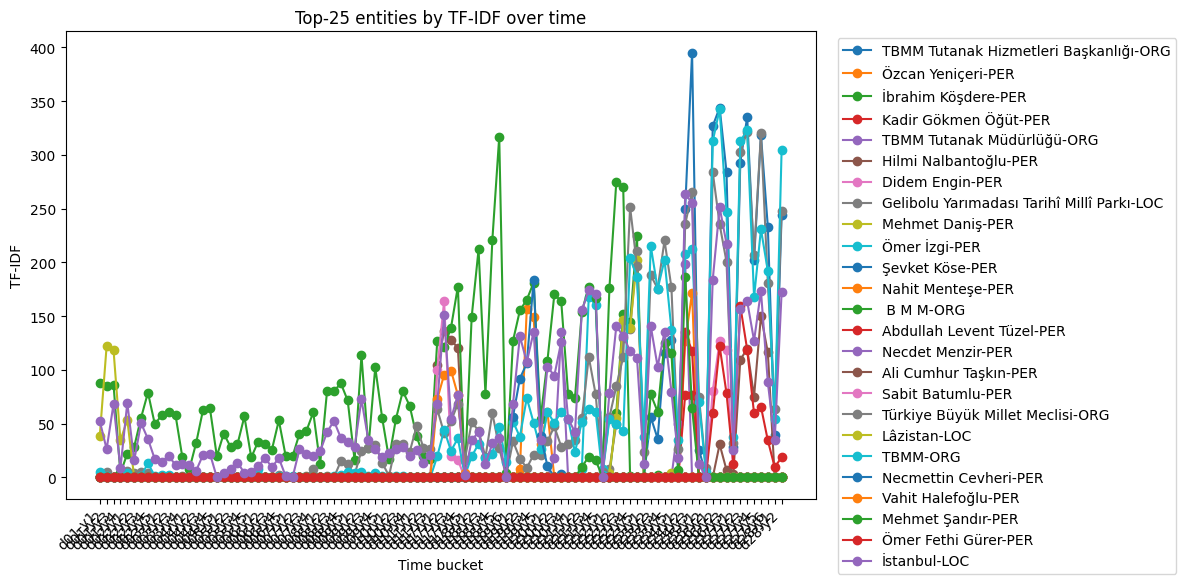

In [16]:
def _dicts_to_csr(entity_counts, rows, cols) -> sparse.csr_matrix:
    r, c, v = [], [], []
    col_idx = {e: i for i, e in enumerate(cols)}
    for i, bucket in enumerate(rows):
        for ent, cnt in entity_counts[bucket].items():
            j = col_idx.get(ent)
            if j is not None:
                r.append(i); c.append(j); v.append(cnt)
    return sparse.csr_matrix((v, (r, c)), shape=(len(rows), len(cols)))


def compute_tfidf(entity_counts, *, min_df=2, smooth_idf=True):
    rows = sorted(entity_counts)
    df = Counter(e for counts in entity_counts.values() for e in counts)
    vocab = [e for e, d in df.items() if d >= min_df]
    if not vocab:
        raise ValueError("No terms survive min_df filtering.")
    X = _dicts_to_csr(entity_counts, rows, vocab)
    tfidf = TfidfTransformer(norm=None, smooth_idf=smooth_idf).fit_transform(X)
    out = {b: {} for b in rows}
    for r, c, val in zip(*tfidf.tocoo().nonzero(), tfidf.data):
        out[rows[r]][vocab[c]] = float(val)
    return out

def plot_top_entities(tfidf_scores, *, top_n=25, ent_filter=None, figsize=(12,6)):
    rec = [(t, e, s)
           for t, d in tfidf_scores.items()
           for e, s in d.items()
           if ent_filter is None or e.endswith(f"-{ent_filter}")]
    if not rec:
        print("Nothing to plot."); return
    df = pd.DataFrame(rec, columns=["time", "entity", "score"]).astype({"time": str})
    top_ents = (df.groupby("entity")["score"].mean()
                  .nlargest(top_n).index)
    pivot = (df[df.entity.isin(top_ents)]
             .pivot(index="time", columns="entity", values="score")
             .fillna(0)
             .sort_index())
    plt.figure(figsize=figsize)
    for ent in top_ents:
        plt.plot(pivot.index, pivot[ent], marker='o', label=ent)
    plt.title(f"Top‑{top_n} entities by TF‑IDF over time")
    plt.xlabel("Time bucket"); plt.ylabel("TF‑IDF")
    plt.xticks(rotation=45, ha="right")
    plt.legend(bbox_to_anchor=(1.02,1), loc="upper left")
    plt.tight_layout(); plt.show()


if __name__ == "__main__":


    # 5.1 gather every raw entity string (filter out nonsense)
    all_entities = [
        ent_key for bucket in grouped_entities.values()
        for e in recombine_subwords(bucket)
        if (ent_key := normalise_entity_key(e)) is not None
    ]

    freq = Counter(all_entities)


    # 5.2 build (or load) alias map
    alias_map = build_alias_map_fast(
        all_entities,
        threshold=90,
        freq=freq,
        workers=-1        
    )

    entity_counts_by_group = {}
    for bucket_key in sorted_keys:
        merged = recombine_subwords(grouped_entities[bucket_key])
        counts = Counter(
            alias_map.get(normalise_entity_key(e), normalise_entity_key(e))
            for e in merged
            if normalise_entity_key(e) is not None  # <-- fix here
        )
        entity_counts_by_group[bucket_key] = dict(counts)


    # 5.4 TF‑IDF + plot
    tfidf_scores = compute_tfidf(entity_counts_by_group, min_df=2)
    plot_top_entities(tfidf_scores, top_n=25)       # ent_filter="ORG"/"LOC"…

In [24]:
import pandas as pd

# Flatten dict
flat = [(time, entity, score)
        for time, ents in tfidf_scores.items()
        for entity, score in ents.items()]

df = pd.DataFrame(flat, columns=["time", "entity", "tfidf"])


In [ ]:
df_loc = df[df["entity"].str.endswith("-LOC")]

# BY MEAN
df_grouped = df_loc.groupby("entity").agg(
    tfidf=("tfidf", "mean"),
    count=("tfidf", "count")
).reset_index()

# Then sort and slice
df_grouped = df_grouped.sort_values("tfidf", ascending=False)

df_grouped.head(30)


,entity,tfidf,count
518,Gelibolu Yarımadası Tarihî Millî Parkı-LOC,107.054109,5
867,Lâzistan-LOC,73.408532,5
1621,İstanbul-LOC,65.822591,95
932,Mersin-LOC,59.893972,46
203,Bayezid-LOC,49.336305,3
1247,Tiirkiye-LOC,45.107479,3
277,Bozok-LOC,44.030524,6
694,Karesi-LOC,43.754263,10
1105,Saruhan-LOC,41.222663,9
1536,Çeçenistan-LOC,40.648574,2


In [38]:
# BY ALL TIME HIGH

df_grouped = df_loc.groupby("entity").agg(
    tfidf=("tfidf", "max"),
    count=("tfidf", "count")
).reset_index()
df_grouped = df_grouped.sort_values("tfidf", ascending=False)

df_grouped.head(30)


,entity,tfidf,count
932,Mersin-LOC,292.985504,46
1621,İstanbul-LOC,263.743854,95
518,Gelibolu Yarımadası Tarihî Millî Parkı-LOC,210.284858,5
90,Ankara-LOC,158.000000,100
1634,İzmir-LOC,147.738154,96
1138,Seyhan-LOC,131.993343,25
867,Lâzistan-LOC,122.347554,5
811,Körfez-LOC,122.254559,10
21,Adıyaman-LOC,120.631015,48
27,Afyonkarahisar-LOC,113.493174,52


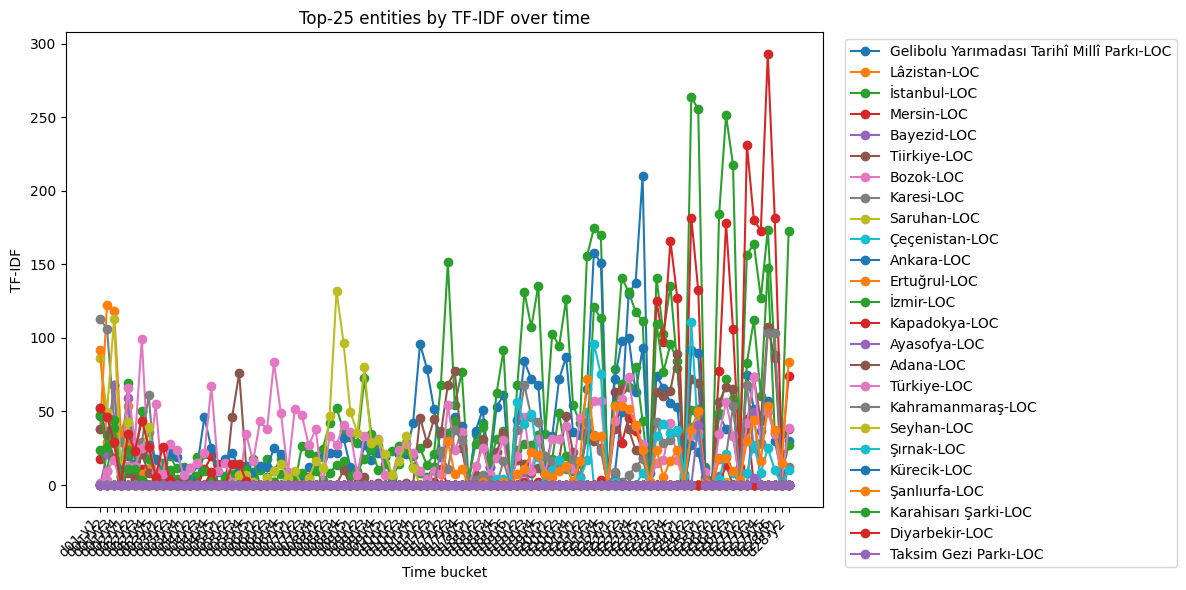

In [17]:
clean_tfidf_scores = {
    t: {e: s for e, s in ents.items() if e is not None}
    for t, ents in tfidf_scores.items()
}
plot_top_entities(clean_tfidf_scores, ent_filter="LOC")   

In [ ]:
df_loc = df[df["entity"].str.endswith("-PER")]

# BY MEAN
df_grouped = df_loc.groupby("entity").agg(
    tfidf=("tfidf", "mean"),
    count=("tfidf", "count")
).reset_index()

df_grouped = df_grouped.sort_values("tfidf", ascending=False)

df_grouped.head(30)


,entity,tfidf,count
4924,Özcan Yeniçeri-PER,149.044772,2
4987,İbrahim Köşdere-PER,145.205994,4
2408,Kadir Gökmen Öğüt-PER,126.462230,2
2243,Hilmi Nalbantoğlu-PER,122.173319,4
1373,Didem Engin-PER,108.539871,3
2760,Mehmet Daniş-PER,91.730259,6
4915,Ömer İzgi-PER,86.122176,4
5232,Şevket Köse-PER,84.119335,4
3355,Nahit Menteşe-PER,81.055254,5
3419,Necdet Menzir-PER,76.780640,2


In [ ]:
df_loc = df[df["entity"].str.endswith("-PER")]

# BY MAX
df_grouped = df_loc.groupby("entity").agg(
    tfidf=("tfidf", "max"),
    count=("tfidf", "count")
).reset_index()


df_grouped = df_grouped.sort_values("tfidf", ascending=False)

df_grouped.head(30)


,entity,tfidf,count
4987,İbrahim Köşdere-PER,224.318226,4
3516,Numan Kurtulmuş-PER,221.754941,5
1397,Durmuş Fikri Sağlar-PER,204.662289,15
2760,Mehmet Daniş-PER,201.806570,6
2933,Mehmet Şandır-PER,186.599064,10
2578,Levent Gök-PER,186.599064,10
3445,Necmettin Cevheri-PER,183.855307,7
2728,Mehmet Ali Çelebi-PER,183.855307,7
4924,Özcan Yeniçeri-PER,171.627313,2
4915,Ömer İzgi-PER,168.238669,4


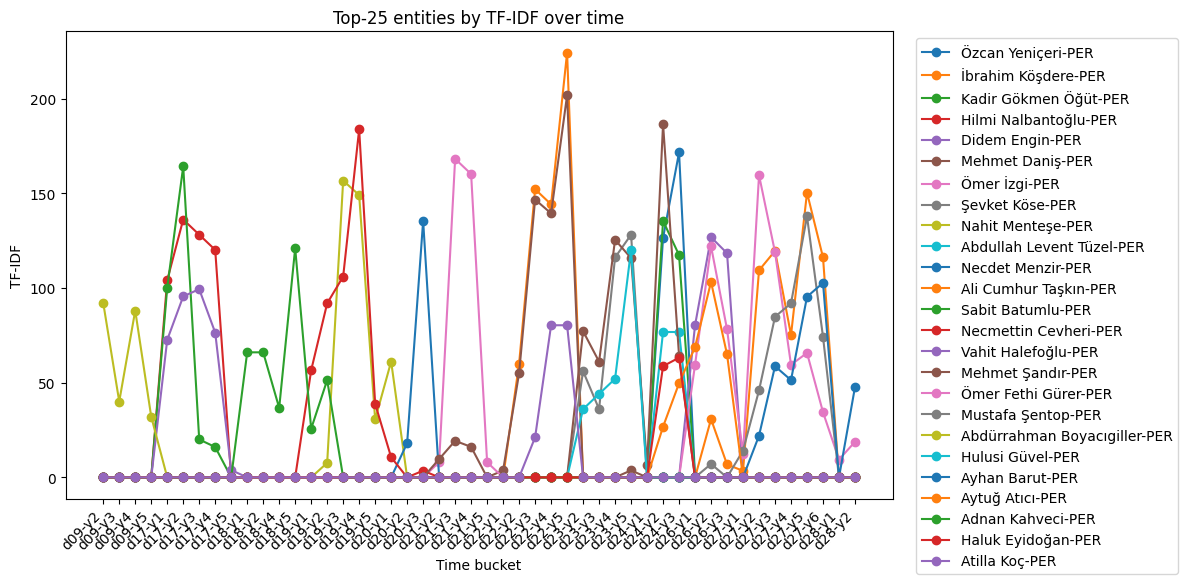

In [18]:
clean_tfidf_scores = {
    t: {e: s for e, s in ents.items() if e is not None}
    for t, ents in tfidf_scores.items()
}
plot_top_entities(clean_tfidf_scores, ent_filter="PER")   

In [ ]:
df_loc = df[df["entity"].str.endswith("-ORG")]

# BY MEAN
df_grouped = df_loc.groupby("entity").agg(
    tfidf=("tfidf", "mean"),
    count=("tfidf", "count")
).reset_index()

df_grouped = df_grouped.sort_values("tfidf", ascending=False)

df_grouped.head(30)


,entity,tfidf,count
1420,TBMM Tutanak Hizmetleri Başkanlığı-ORG,221.527978,15
1421,TBMM Tutanak Müdürlüğü-ORG,124.203976,2
32,B M M-ORG,80.603757,79
1603,Türkiye Büyük Millet Meclisi-ORG,74.580658,78
1423,TBMM-ORG,72.702486,74
353,Biiyiik Millet Meclisi-ORG,54.974740,3
977,Lâyiha Encümeni-ORG,53.736686,9
587,Divanı Riyaset-ORG,49.866991,10
820,Hazine ve Dış Ticaret Müsteşarlığı-ORG,42.684735,11
391,Bütçe Encümeni-ORG,41.352069,17


In [ ]:
df_loc = df[df["entity"].str.endswith("-ORG")]

# BY MAX
df_grouped = df_loc.groupby("entity").agg(
    tfidf=("tfidf", "max"),
    count=("tfidf", "count")
).reset_index()

df_grouped = df_grouped.sort_values("tfidf", ascending=False)

df_grouped.head(30)


,entity,tfidf,count
1420,TBMM Tutanak Hizmetleri Başkanlığı-ORG,395.111919,15
1423,TBMM-ORG,342.574954,74
1603,Türkiye Büyük Millet Meclisi-ORG,321.383547,78
32,B M M-ORG,316.905128,79
1045,Meclis-ORG,256.820957,94
1421,TBMM Tutanak Müdürlüğü-ORG,198.726362,2
152,Adliye Vekâleti-ORG,183.357177,19
820,Hazine ve Dış Ticaret Müsteşarlığı-ORG,178.422190,11
587,Divanı Riyaset-ORG,151.209586,10
144,Adliye Encümeni-ORG,129.397213,24


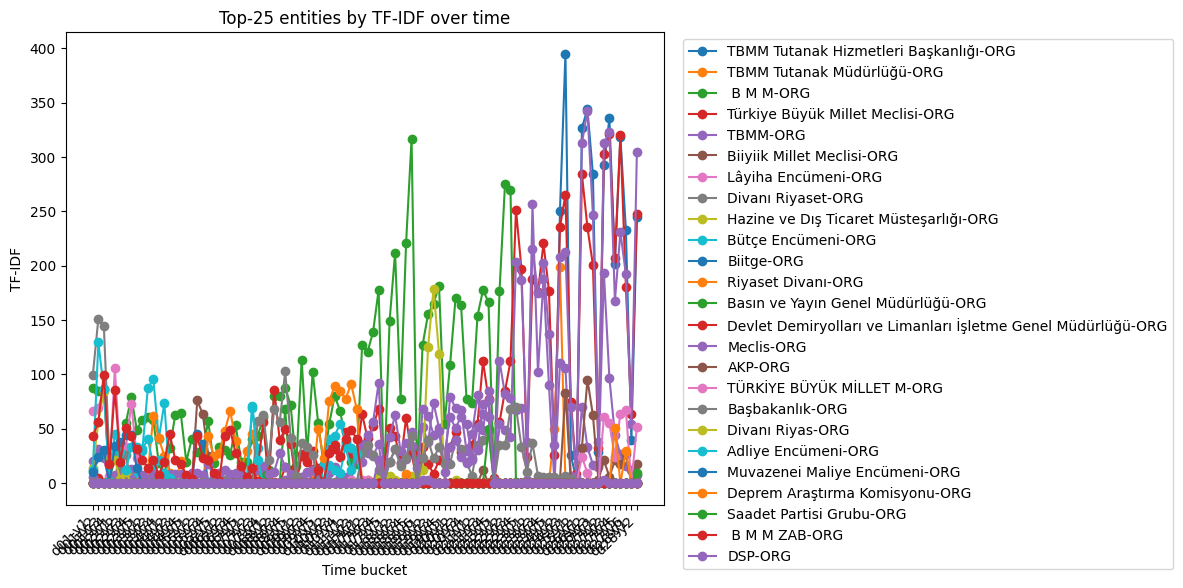

In [ ]:

clean_tfidf_scores = {
    t: {e: s for e, s in ents.items() if e is not None}
    for t, ents in tfidf_scores.items()
}
plot_top_entities(clean_tfidf_scores, ent_filter="ORG")     

In [ ]:
import pandas as pd
import pickle, os

cache_path = "alias_map.pkl"

if not os.path.exists(cache_path):
    raise FileNotFoundError("alias_map.pkl not found. Make sure you've run the alias-building code so it creates the cache.")

with open(cache_path, "rb") as f:
    _sig, alias_map = pickle.load(f)

# Build a DF
rows = [(canon, raw) for (raw, canon) in alias_map.items()]
df = pd.DataFrame(rows, columns=["canonical", "variant"]).sort_values(["canonical", "variant"])


df


,canonical,variant
43,Lpaydm î Kirazoğlu-PER,Lpaydm î Kirazoğlu-PER
79,1 M I-ORG,1 M I-ORG
80,1 M I-ORG,Mî-ORG
81,1 M M A-ORG,1 M M A-ORG
82,1 M M BIMMITI-ORG,1 M M BIMMITI-ORG
...,...,...
31837,şilay Cemiyeti-ORG,şilay Cemiyeti-ORG
36670,şilbağ-LOC,şilbağ-LOC
36671,şit Traçıoğlu-PER,şit Traçıoğlu-PER
36672,şuabali Demiryallan İşletme İdaresi-ORG,şuabali Demiryallan İşletme İdaresi-ORG
